# Import

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import statistics
from scipy import signal, stats
from scipy.optimize import curve_fit
from cycler import cycler

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
#%matplotlib widget

# Data structure

In [4]:
scalars = [{'label' : 'Sc=1', 'i' : 1, 'Sc': 1.0, 'Rl' : 70, 'N': 160, 'folder' : 'N160/Rl70_Sc1/', 'runs' : [82], 'spec_ite' : 100000, 'h5_ite' : 100000},
          {'label' : 'Sc=1 $k_f=8$ for sca (N=160)', 'i' : 1, 'Sc': 1.0, 'Rl' : 70, 'N': 160, 'folder' : 'N160/Rl70_Sc1_forc2/', 'runs' : [82], 'spec_ite' : 100000, 'h5_ite' : 100000},
          {'label' : r'Sc=1 $k_f=8$ for vel (N=480)', 'i' : 1, 'Sc': 1.0, 'Rl' : 70, 'N': 480, 'folder' : 'N480/Rl70_Sc10_forcing2/', 'runs' : [1], 'spec_ite' : 16000, 'h5_ite' : 16000},
          {'label' : 'Sc=2', 'i' : 1, 'Sc': 2.0, 'Rl' : 70, 'N': 320, 'folder' : 'N160/Rl70_Sc4/', 'runs' : [24], 'spec_ite' : 28000, 'h5_ite' : 30000},
          {'label' : 'Sc=3', 'i' : 2, 'Sc': 3.0, 'Rl' : 70, 'N': 320, 'folder' : 'N160/Rl70_Sc4/', 'runs' : [24], 'spec_ite' : 28000, 'h5_ite' : 30000},
          {'label' : 'Sc=4', 'i' : 3, 'Sc': 4.0, 'Rl' : 70, 'N': 320, 'folder' : 'N160/Rl70_Sc4/', 'runs' : [24], 'spec_ite' : 28000, 'h5_ite' : 30000},
          {'label' : 'Sc=9', 'i' : 1, 'Sc': 9.0, 'Rl' : 70, 'N': 480, 'folder' : 'N160/Rl70_Sc9/', 'runs' : [5], 'spec_ite' : 16000, 'h5_ite' : 16000},
          {'label' : 'Sc=16', 'i' : 1, 'Sc': 16.0, 'Rl' : 70, 'N': 640, 'folder' : 'N160/Rl70_Sc16/', 'runs' : [3], 'spec_ite' : 12000, 'h5_ite' : 12000}]

In [5]:
viscosity = 0.0001
L = 2.1; Urms = 0.20816300E-01;
T0 = L/Urms
print(T0)

100.88248151688822


In [6]:
for simu in scalars :
    simu.update({'diffusivity': viscosity/simu["Sc"]})

# Reading data

In [7]:
#read correlation files
def read_data_file(common_folder, file_type, spec_type, spec_component, run_files) :
    nb_of_runs = len(run_files)
    for run_index in list(range(nb_of_runs)) :
        folder = common_folder + "run" + "%01d" % (run_index+1) + "/"
        if (run_files[run_index] < 1000) :
            file = folder + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%03d" % run_files[run_index] + ".table"
        else : 
            file = folder + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%06d" % run_files[run_index] + ".table"
        file_data = []
        print('reading file: ' + file)
        averaging_weight = (run_files[run_index]+1)/(sum(run_files)+nb_of_runs)
        for line in open(file) :
            temp_array_line = []
            if line[0] == '#' :          #skip commented lines
                continue
            else :
                temp_array_line=list(map(float, line.split( )))
                temp_array_line = [t * averaging_weight for t in temp_array_line]
                file_data.append(temp_array_line)  
        if (run_index == 0) : 
            accumulated_data = file_data.copy()
        else : 
            accumulated_data = list(map(lambda l1, l2: [sum(x) for x in zip(l1, l2)], accumulated_data, file_data))
    k = np.array(accumulated_data[0])
    nb_of_modes = np.array(accumulated_data[1])
    average_data = np.ndarray(shape=(len(accumulated_data)-2, k.shape[0]+1), dtype=float)
    for i in list(range(average_data.shape[0])) : 
        average_data[i, :] = np.array(accumulated_data[i+2])
    t = average_data[:,0]
    numpy_file_table = np.array(average_data[:,1:])
    return [k, nb_of_modes, t, numpy_file_table]

In [8]:
# read velocity spectrum file
def read_spec_file(common_folder, forlder_in, quantity, spec_type, ite) :
    file = common_folder + forlder_in + quantity + "_" + spec_type + "_ite=%06d" % ite + ".table"
    print('reading file: ' + file)
    file_data = []
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            temp_array_line=list(map(float, line.split( )))
            file_data.append(temp_array_line)  
    spec_table = np.array(file_data)
    k = spec_table[:,0]
    nb_of_modes = spec_table[:,1]
    Ek = spec_table[:,2]
#     Exx = spec_table[:,3]
#     Eyy = spec_table[:,4]
#     Ezz = spec_table[:,5]
    #return [k, nb_of_modes, Ek, Exx, Eyy, Ezz, spec_table[:,6], spec_table[:,7], spec_table[:,8], spec_table[:,9]]
    return [k, nb_of_modes, Ek]

In [9]:
common_folder = "/home/gorbunov8a/data/scalar/"
spec_type = "lin"
spec_component = "avg"
file_type = "two_point_corr_complex"

In [10]:
# read data files
for index,simu in np.ndenumerate(scalars) :
    i = index[0]
    [k, nb_of_modes, t, scalar_two_point_corr] = read_data_file(common_folder + simu['folder'], "scalar%01d" % simu['i'] + "_two_point_corr_complex", "lin", "avg", simu['runs'])
    simu.update({'k' : k, 'nb_of_modes': nb_of_modes, 'scalar_corr': scalar_two_point_corr, 'scalar_t' : t})
    [k, nb_of_modes, t, sc_avg] = read_data_file(common_folder + simu['folder'], "scalar%01d" % simu['i'] + "_avg_real", "lin", "avg", simu['runs'])
    simu.update({'scalar_avg' : sc_avg})
    [k, nb_of_modes, S2] = read_spec_file(common_folder+ simu['folder'], "run1/", "spectrum_scalar%01d" % simu['i'], "lin", simu['spec_ite'])
    simu.update({'scal_spec': S2})
[k_vel, nb_of_modes_vel, Ek_vel] = read_spec_file(common_folder + scalars[1]['folder'], "run1/", "vel_spec", "lin", scalars[1]['spec_ite'])
[k_vel, nb_of_modes_vel, t, vel_two_point_corr] = read_data_file(common_folder + scalars[1]['folder'], "two_point_corr_complex_real", "lin", "avg", scalars[1]['runs'])

reading file: /home/gorbunov8a/data/scalar/N160/Rl70_Sc1/run1/scalar1_two_point_corr_complex_lin_Cavg_wi=082.table
reading file: /home/gorbunov8a/data/scalar/N160/Rl70_Sc1/run1/scalar1_avg_real_lin_Cavg_wi=082.table
reading file: /home/gorbunov8a/data/scalar/N160/Rl70_Sc1/run1/spectrum_scalar1_lin_ite=100000.table
reading file: /home/gorbunov8a/data/scalar/N160/Rl70_Sc1_forc2/run1/scalar1_two_point_corr_complex_lin_Cavg_wi=082.table
reading file: /home/gorbunov8a/data/scalar/N160/Rl70_Sc1_forc2/run1/scalar1_avg_real_lin_Cavg_wi=082.table
reading file: /home/gorbunov8a/data/scalar/N160/Rl70_Sc1_forc2/run1/spectrum_scalar1_lin_ite=100000.table
reading file: /home/gorbunov8a/data/scalar/N480/Rl70_Sc10_forcing2/run1/scalar1_two_point_corr_complex_lin_Cavg_wi=001.table
reading file: /home/gorbunov8a/data/scalar/N480/Rl70_Sc10_forcing2/run1/scalar1_avg_real_lin_Cavg_wi=001.table
reading file: /home/gorbunov8a/data/scalar/N480/Rl70_Sc10_forcing2/run1/spectrum_scalar1_lin_ite=016000.table
read

# Parameters

In [11]:
# Plotting options
plt.rc('axes', labelsize=16)  
plt.rc('axes', titlesize=16)  
plt.rc('legend', fontsize=14)  

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
default_cycler = cycler(cycler(linestyle=['-', '--', ':', '-.'])*cycler(color=colors))
plt.rc('axes', prop_cycle=default_cycler)

In [12]:
kmin = 4
kmax = np.max(k_vel)-6
kmax = 15
nb_of_curves = 10
step = round((kmax - kmin)/nb_of_curves)
indices_of_k_to_plot = np.arange(kmin,kmax,step, dtype=np.int16)
print(indices_of_k_to_plot)

[ 4  5  6  7  8  9 10 11 12 13 14]


In [13]:
for index, sca in enumerate(scalars) :
#     kmax = np.max(sca['k'])-6
#     kmax=74
    sca['indices_of_k_to_plot'] = np.arange(kmin,kmax,round((kmax - kmin)/nb_of_curves), dtype=np.int16)

# Spectra

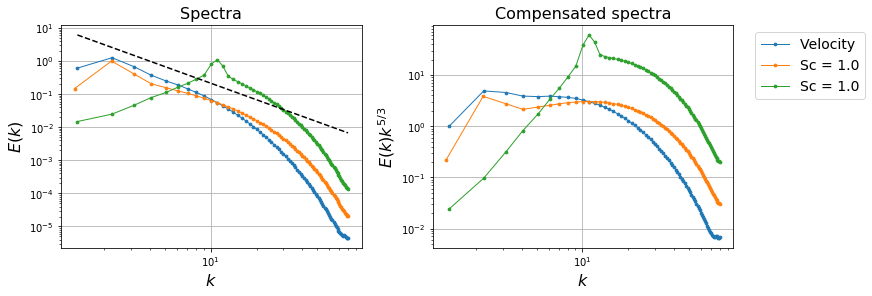

In [14]:
plt.ion()
fig, ax = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(12,4))

normalization = 1.0/np.max(Ek_vel)
ax[0].plot(k_vel, Ek_vel*4.0*np.pi*(k_vel**2)/nb_of_modes_vel*normalization, '.-', lw=1.0, markersize=5.5, label='Velocity')
ax[1].plot(k_vel, Ek_vel*4.0*np.pi*(k_vel**2)/nb_of_modes_vel*(k_vel**(5.0/3.0))*normalization, '.-', lw=1.0, markersize=5.5, label='Velocity')
for index,simu in np.ndenumerate(scalars[0:2]) :
    i = index[0]
    ax[0].plot(simu['k'], simu['scal_spec']*4.0*np.pi*(simu['k']**2)/simu['nb_of_modes']/np.max(simu['scal_spec']), '.-', lw=1.0, markersize=5.5, label='Sc = %2.1f' % simu['Sc'])
    ax[1].plot(simu['k'], simu['scal_spec']*4.0*np.pi*(simu['k']**2)/simu['nb_of_modes']*(simu['k']**(5.0/3.0))/np.max(simu['scal_spec']), '.-', lw=1.0, markersize=5.5, label='Sc = %2.1f' % simu['Sc'])
ax[0].plot(simu['k'], 1e1*simu['k']**(-5.0/3.0), 'k--', label=r'$k^{-5/3}$')
ax[0].set(xscale='log', yscale='log', xlabel=r'$k$', ylabel=r'$E(k)$', title=r'Spectra'); ax[0].grid()
ax[1].set(xscale='log', yscale='log', xlabel=r'$k$', ylabel=r'$E(k)k^{5/3}$', title=r'Compensated spectra'); ax[1].grid()
lgd = ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# pp = PdfPages('../Images/Scalar/spec_scalar_compens_eps43_N192_diff_u.pdf')
# pp.savefig(bbox_extra_artists=lgd,), bbox_inches='tight')
# pp.close()
#plt.show()

# 2-point time correlations

In [15]:
nb_of_rows = 2
nb_of_cols = 4
table=np.arange(-1,7).reshape(nb_of_rows,nb_of_cols)

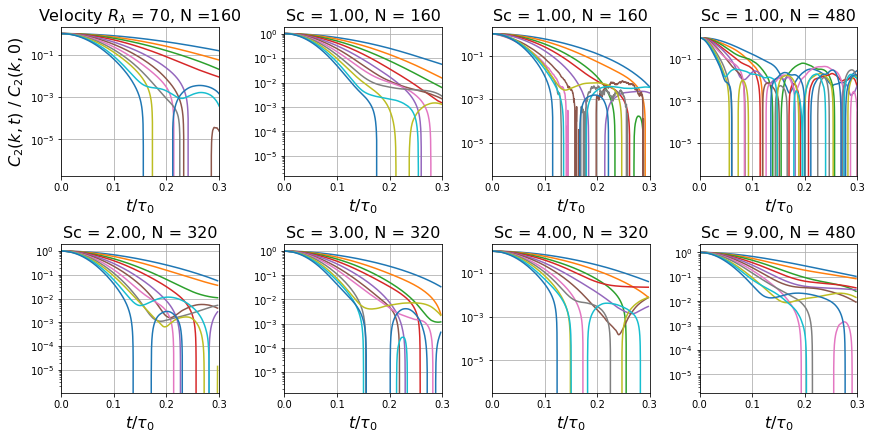

In [16]:
x_max = 0.3
fig, ax = plt.subplots(nrows=nb_of_rows, ncols=nb_of_cols, constrained_layout=True,figsize=(12,6))
for index, isca in np.ndenumerate(table) :
    if (isca == -1) :
        for ik in indices_of_k_to_plot :
            ax[index].plot(t/T0, vel_two_point_corr[:,ik]/vel_two_point_corr[0,ik], '-', label=r'$k$=%2.2f' % (k_vel[ik]))
        ax[index].set(xlim=[0,x_max], xscale='linear',yscale='log', xlabel=r'$t/\tau_0$', ylabel=r'$C_2(k,t) \ / \ C_2(k,0)$', title=r'Velocity $R_\lambda$ = 70, N =160'); 
        ax[index].grid()
        #ax[index].legend(loc='lower left',fontsize=10)
    else:
        sca=scalars[isca]
        for ik in sca['indices_of_k_to_plot'] :
            scaling = 1.0/T0
            ax[index].plot(sca['scalar_t']*scaling, (sca['scalar_corr'][:,ik])/sca['scalar_corr'][1,ik], '-', label=r'$k$=%2.2f' % (sca['k'][ik]))
            #ax[index + 1].plot(sca['scalar_t']*scaling, (sca['scalar_corr'][:,ik] - sca['scalar_avg'][:,ik]*sca['scalar_avg'][0,ik])/sca['scalar_corr'][0,ik], '.-', label=r'$k$=%2.2f' % (sca['k'][ik]))
        ax[index].set(xlim=[0,x_max], xscale='linear',yscale='log', xlabel=r'$t/\tau_0$', title=r'Sc = %2.2f, N = %2.0f' % (sca['Sc'], sca['N'])); 
        ax[index].grid()
    #    ax[index].legend(loc='lower left',fontsize=10)

# pp = PdfPages('../Images/Scalar/vel_and_scalar_corr_Rl90_Sc07.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

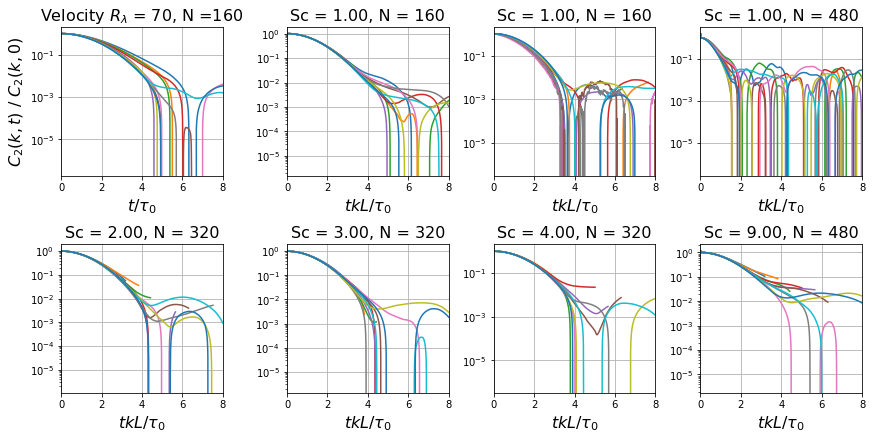

In [17]:
x_max = 8
fig, ax = plt.subplots(nrows=nb_of_rows, ncols=nb_of_cols, constrained_layout=True,figsize=(12,6))
for index, isca in np.ndenumerate(table) :
    if (isca == -1) :
        for ik in indices_of_k_to_plot :
            ax[index].plot(t*k_vel[ik]*L/T0, vel_two_point_corr[:,ik]/vel_two_point_corr[0,ik], '-', label=r'$k$=%2.2f' % (k_vel[ik]))
        ax[index].set(xlim=[0,x_max], xscale='linear',yscale='log', xlabel=r'$t/\tau_0$', ylabel=r'$C_2(k,t) \ / \ C_2(k,0)$', title=r'Velocity $R_\lambda$ = 70, N =160'); 
        ax[index].grid()
        #ax[index].legend(loc='lower left',fontsize=10)
    else:
        sca=scalars[isca]
        for ik in sca['indices_of_k_to_plot'] :
            scaling = sca['k'][ik]*L/T0
            ax[index].plot(sca['scalar_t']*scaling, (sca['scalar_corr'][:,ik])/sca['scalar_corr'][1,ik], '-', label=r'$k$=%2.2f' % (sca['k'][ik]))
            #ax[index + 1].plot(sca['scalar_t']*scaling, (sca['scalar_corr'][:,ik] - sca['scalar_avg'][:,ik]*sca['scalar_avg'][0,ik])/sca['scalar_corr'][0,ik], '.-', label=r'$k$=%2.2f' % (sca['k'][ik]))
        ax[index].set(xlim=[0,x_max], xscale='linear',yscale='log', xlabel=r'$t k L/\tau_0$', title=r'Sc = %2.2f, N = %2.0f' % (sca['Sc'], sca['N'])); 
        ax[index].grid()
    #    ax[index].legend(loc='lower left',fontsize=10)

# pp = PdfPages('../Images/Scalar/vel_and_scalar_corr_Rl90_Sc07.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

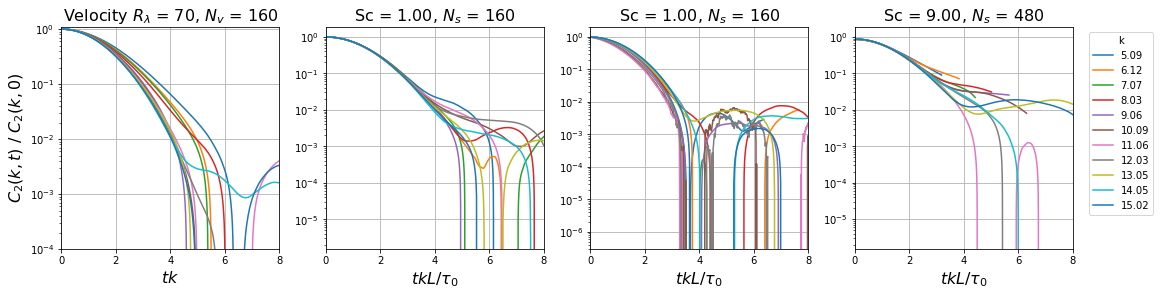

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=4, constrained_layout=True,figsize=(16,4))
x_max = 8

for ik in indices_of_k_to_plot :
    ax[0].plot(t*k_vel[ik]*L/T0, vel_two_point_corr[:,ik]/vel_two_point_corr[1,ik], '-', label=r'$k$=%2.2f' % (k_vel[ik]))
ax[0].set(xlim=[0,x_max], ylim=[10e-5,1.1], xscale='linear',yscale='log', xlabel=r'$t k$', ylabel=r'$C_2(k,t) \ / \ C_2(k,0)$', title=r'Velocity $R_\lambda$ = 70, $N_v$ = 160'); ax[0].grid()
#ax[0].legend(loc='lower left',fontsize=10)

sca_indices = [0,1, 6]
for index, sca in enumerate(np.take(scalars, sca_indices)) :
    for ik in sca['indices_of_k_to_plot'] :
        scaling = sca['k'][ik]*L/T0
        ax[index + 1].plot(sca['scalar_t']*scaling, (sca['scalar_corr'][:,ik]/sca['scalar_corr'][0,ik]), '-', label=r'%2.2f' % (sca['k'][ik]))
        #ax[index + 1].plot(sca['scalar_t']*scaling, (sca['scalar_corr'][:,ik] - sca['scalar_avg'][:,ik]*sca['scalar_avg'][0,ik])/sca['scalar_corr'][0,ik], '.-', label=r'$k$=%2.2f' % (sca['k'][ik]))
    ax[index + 1].set(xlim=[0,x_max], xscale='linear',yscale='log', xlabel=r'$t k L/\tau_0$', title=r'Sc = %2.2f, $N_s$ = %2.0f' % (sca['Sc'], sca['N'])); ax[index + 1].grid()
lgd = ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left',title='k',fontsize=10)

# pp = PdfPages('../Images/Scalar/vel_and_scalar_corr_Rl90_Sc9.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

# Crossover

In [19]:
# compute time derivatives of the corr function
for simu in scalars : 
    simu['deriv1'] = np.ndarray(shape=(len(simu['k']), len(simu['scalar_t'])-1), dtype=float)
    simu['deriv2'] = np.ndarray(shape=(len(simu['k']), len(simu['scalar_t'])-1), dtype=float)
    for ik in range(len(simu['k'])) :
        sl = np.s_[1:len(simu['scalar_t'])]
        simu['deriv1'][ik,:] = np.gradient(simu['scalar_corr'][sl,ik] / simu['scalar_corr'][1,ik], simu['scalar_t'][sl], edge_order=1)
        simu['deriv2'][ik,:] = np.gradient(simu['deriv1'][ik,:] / (simu['scalar_corr'][sl,ik] / simu['scalar_corr'][1,ik]), simu['scalar_t'][sl], edge_order=1)

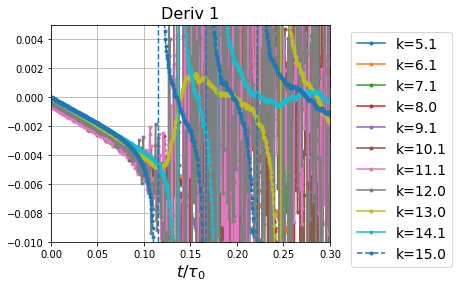

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
simu = scalars[1]
sl=np.s_[1::]
for ik in scalars[0]['indices_of_k_to_plot'] :
#for ik in simu['indices_of_k_to_plot'] :
    scaling = 1.0/T0
    ax.plot(scaling*simu['scalar_t'][sl],simu['deriv1'][ik]/ (simu['scalar_corr'][1:,ik] / simu['scalar_corr'][1,ik])/(simu['k'][ik])**2, marker='.', label='k=%2.1f' % (simu['k'][ik]))
ax.set(xlim=[0,0.3], ylim=(-0.01,0.005), xlabel=r'$t/\tau_0$', title='Deriv 1'); ax.grid()
#ax.axvline(x=simu['Te'], color='k')
gd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Correlation fit

In [21]:
def simple_gaussian(x, a, b, c):   
    return np.exp(-a * (x)**2.0 + b*x + c) 
def simple_gaussian_jacobian(x, a, b, c):   
    return np.transpose([-(x**2.0)*np.exp(-a * (x)**2.0 +b*x + c), x*np.exp(-a * (x)**2.0 + b*x + c) ,np.exp(-a * (x)**2.0 + b*x + c)])

def simple_exp(x, a, c):   
    return np.exp(-a * x + c) 
def simple_exp_jacobian(x, a, c):   
    return np.transpose([-x*np.exp(-a * x + c), np.exp(-a * x + c)])

def linear_fun(x, a, b):   
    return (a * x + b) 
def linear_jacobian(x, a, b):   
    return np.transpose([x, np.ones_like(x)])

## Fitting (iterative method)

Fitting the scalars correlations function :

In [22]:
for sca in scalars :
    sca['tk_end_fit'] = 1.5

In [23]:
#scalars[1]['tk_end_fit'] = 1.0

In [24]:
nb_of_params = 3
for sca in scalars :
    sca['fit_coef'] = np.zeros((len(sca['k']), nb_of_params), dtype=float); sca['fit_coef_error'] = np.zeros((len(sca['k']), nb_of_params), dtype=float)
    sca['chi2'] = np.zeros(len(sca['k']), dtype=float)
    for ik, k in enumerate(sca['k']) :
        xdata = sca['scalar_t']*k*L/T0
        ydata = (sca['scalar_corr'][:,ik])/sca['scalar_corr'][1,ik]
        #a = np.searchsorted(xdata, 0.0)
        a = 1
        b = np.searchsorted(xdata, sca['tk_end_fit'])
        if ((b-a) > 3) :
            coef, covar = curve_fit(simple_gaussian, xdata[a:b], ydata[a:b], jac=simple_gaussian_jacobian, absolute_sigma=False)
            sca['fit_coef'][ik] = coef
            sca['fit_coef_error'][ik] = np.sqrt(np.diagonal(covar))
            sca['chi2'][ik] = np.sum((ydata-simple_gaussian(xdata,*coef))**2)

Fitting the velocity correlations functions :

In [25]:
tk_end_fit = 2.0
vel_fit_coef = np.zeros((len(k_vel), nb_of_params), dtype=float); vel_fit_coef_error = np.zeros((len(k_vel), nb_of_params), dtype=float)
vel_fit_chi2 = np.zeros(len(k_vel), dtype=float)
for ik, k in enumerate(k_vel) :
    xdata = t*k*L/T0
    ydata = vel_two_point_corr[:,ik]/vel_two_point_corr[0,ik]
    a = 0
    b = np.searchsorted(xdata, tk_end_fit)
    coef, covar = curve_fit(simple_gaussian, xdata[a:b], ydata[a:b], jac=simple_gaussian_jacobian, absolute_sigma=False)
    vel_fit_coef[ik] = coef
    vel_fit_coef_error[ik] = np.sqrt(np.diagonal(covar))
    vel_fit_chi2[ik] = np.sum((ydata-simple_gaussian(xdata,*coef))**2)

Plot results of fitting :

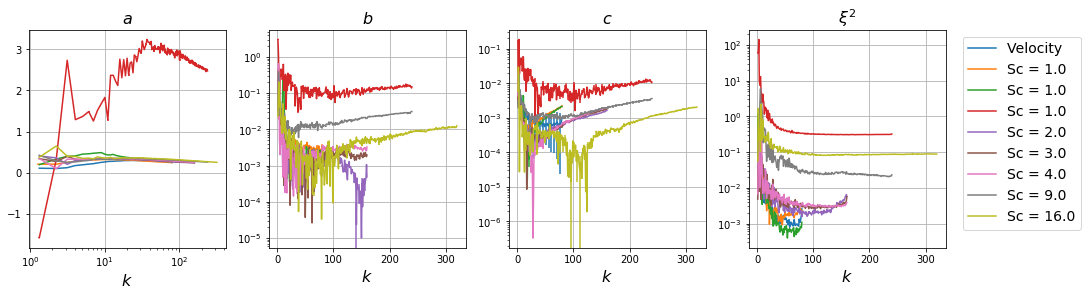

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=4, constrained_layout=True,figsize=(15,4))

ax[0].errorbar(k_vel, vel_fit_coef[:,0], yerr=vel_fit_coef_error[:,0],errorevery=5, label='Velocity')
ax[1].errorbar(k_vel, vel_fit_coef[:,1], yerr=vel_fit_coef_error[:,1],errorevery=5, label='Velocity')
ax[2].errorbar(k_vel, vel_fit_coef[:,2], yerr=vel_fit_coef_error[:,1],errorevery=5, label='Velocity')
ax[3].plot(k_vel, vel_fit_chi2, label='Velocity')
for sca in scalars : 
    ax[0].errorbar(sca['k'], sca['fit_coef'][:,0], yerr=sca['fit_coef_error'][:,0],errorevery=5, label='Sc = %2.1f' % (sca['Sc']))
    ax[1].errorbar(sca['k'], np.abs(sca['fit_coef'][:,1]), yerr=sca['fit_coef_error'][:,1],errorevery=5, label='Sc = %2.1f' % (sca['Sc']))
    ax[2].errorbar(sca['k'], np.abs(sca['fit_coef'][:,2]), yerr=sca['fit_coef_error'][:,2],errorevery=5, label='Sc = %2.1f' % (sca['Sc']))
    ax[3].plot(sca['k'], sca['chi2'], label='Sc = %2.1f' % (sca['Sc']))
ax[0].set(xlabel=r'$k$', title=r'$a$', xscale='log'); ax[0].grid()
ax[1].set(xlabel=r'$k$', title=r'$b$', yscale='log'); ax[1].grid()
ax[2].set(xlabel=r'$k$', title=r'$c$', yscale='log'); ax[2].grid()
ax[3].set(xlabel=r'$k$', title=r'$\xi^2$', yscale='log'); ax[3].grid()
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

## Time scales

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in power
  


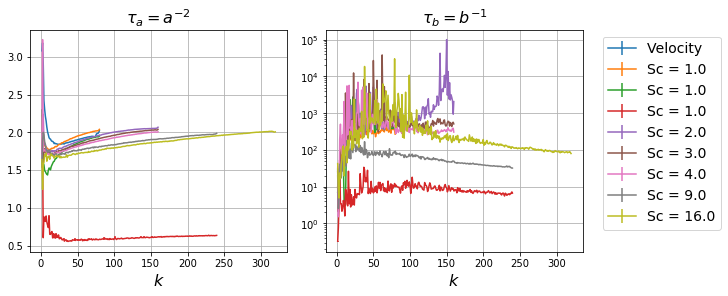

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(10,4))

ax[0].errorbar(k_vel, (vel_fit_coef[:,0])**(-0.5), yerr=vel_fit_coef_error[:,0],errorevery=5, label='Velocity')
ax[1].errorbar(k_vel, (vel_fit_coef[:,1])**(-1.0), yerr=vel_fit_coef_error[:,1],errorevery=5, label='Velocity')
for sca in scalars : 
    ax[0].errorbar(sca['k'], (sca['fit_coef'][:,0])**(-0.5), yerr=sca['fit_coef_error'][:,0],errorevery=5, label='Sc = %2.1f' % (sca['Sc']))
    ax[1].errorbar(sca['k'], (np.abs(sca['fit_coef'][:,1]))**(-1.0), yerr=sca['fit_coef_error'][:,1],errorevery=5, label='Sc = %2.1f' % (sca['Sc']))
ax[0].set(xlabel=r'$k$', title=r'$\tau_a = a^{-2}$'); ax[0].grid()
ax[1].set(xlabel=r'$k$', title=r'$\tau_b = b^{-1}$', yscale='log'); ax[1].grid()

ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Physical fields

In [28]:
import h5py

In [29]:
sca = scalars[0]

# Read velocity fields
file = h5py.File(common_folder + sca['folder'] + 'run1/' + 'U_' + "%06d" % sca['h5_ite'] + '.h5', 'r')
sca['U'] = file['U'][:,:] # copy the file data into a numpy array
file.close()

In [30]:
# Read scalar fields

for index, sca in enumerate(scalars) :
    file = h5py.File(common_folder + sca['folder'] + 'run1/' + 'ScalarS%01d' % sca['i'] + '_' + "%06d" % sca['h5_ite'] + '.h5', 'r')
    sca['scal_field'] = file['ScalarS%01d' % sca['i']][:,:] # copy the file data into a numpy array
    file.close()

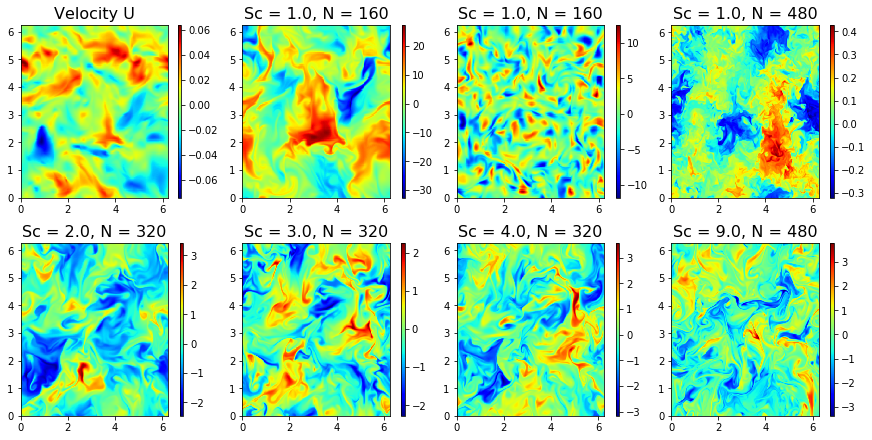

In [31]:
x_cut=40

fig, ax = plt.subplots(nrows=nb_of_rows, ncols=nb_of_cols, constrained_layout=True,figsize=(12,6))
for index, isca in np.ndenumerate(table) :
    if (isca == -1) :
        sca = scalars[0]
        x_scal = 2.0*np.pi/sca['N']*np.arange(0,sca['N'])
        im = ax[0,0].pcolormesh(x_scal, x_scal, sca['U'][x_cut, :,:], cmap='jet')
        ax[0,0].set(xscale='linear', yscale='linear', title='Velocity U')
        fig.colorbar(im, ax=ax[0,0], aspect=100)
    else :
        sca=scalars[isca]
        x_scal = 2.0*np.pi/sca['N']*np.arange(0,sca['N'])
        im = ax[index].pcolormesh(x_scal, x_scal, sca['scal_field'][x_cut, :,:], cmap='jet')
        ax[index].set(xscale='linear', yscale='linear', title='Sc = %2.1f, N = %3.0f' % (sca['Sc'], sca['N']))
        fig.colorbar(im, ax=ax[index], aspect=100)

#plt.savefig("../Images/Scalar/fields_eps43_N192_diff_u.png", dpi=150, format="png")
plt.show()

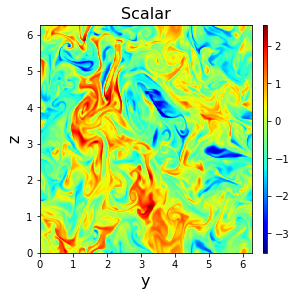

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(4,4))
sca=scalars[6]
x_scal = 2.0*np.pi/sca['N']*np.arange(0,sca['N'])
im = ax.pcolormesh(x_scal, x_scal, sca['scal_field'][200, :,:], cmap='jet')
ax.set(xlabel='y', ylabel='z', xscale='linear', yscale='linear', title='Scalar')
fig.colorbar(im, ax=ax, aspect=50)
#plt.savefig("../Images/Scalar/real_scalar_Rl70_Sc16_N640.png", dpi=150, format="png")
plt.show()

In [33]:
from mpl_toolkits.mplot3d import Axes3D

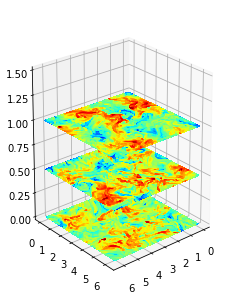

In [45]:
sca=scalars[7]
x_scal = 2.0*np.pi/sca['N']*np.arange(0,sca['N'])

X,Y = np.meshgrid(x_scal,x_scal)
A1 = sca['scal_field'][10, :,:]
A2 = sca['scal_field'][100,:, :]
A3 = sca['scal_field'][300,:,:]
 
fig = plt.figure(figsize=plt.figaspect(4/3))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, 50)
ax.contourf(X, Y, A1, 100, zdir='z', offset=0, cmap='jet')
ax.contourf(X, Y, A2, 100, zdir='z', offset=0.5, cmap='jet')
ax.contourf(X, Y, A3, 100, zdir='z', offset=1, cmap='jet')
 
ax.set_zlim((0.,1.5))
 
plt.show()